In [2]:
import yfinance as yf

In [9]:
ticker = yf.Ticker('AAPL')
balance_sheet = ticker.balance_sheet
option_chain = ticker.option_chain()

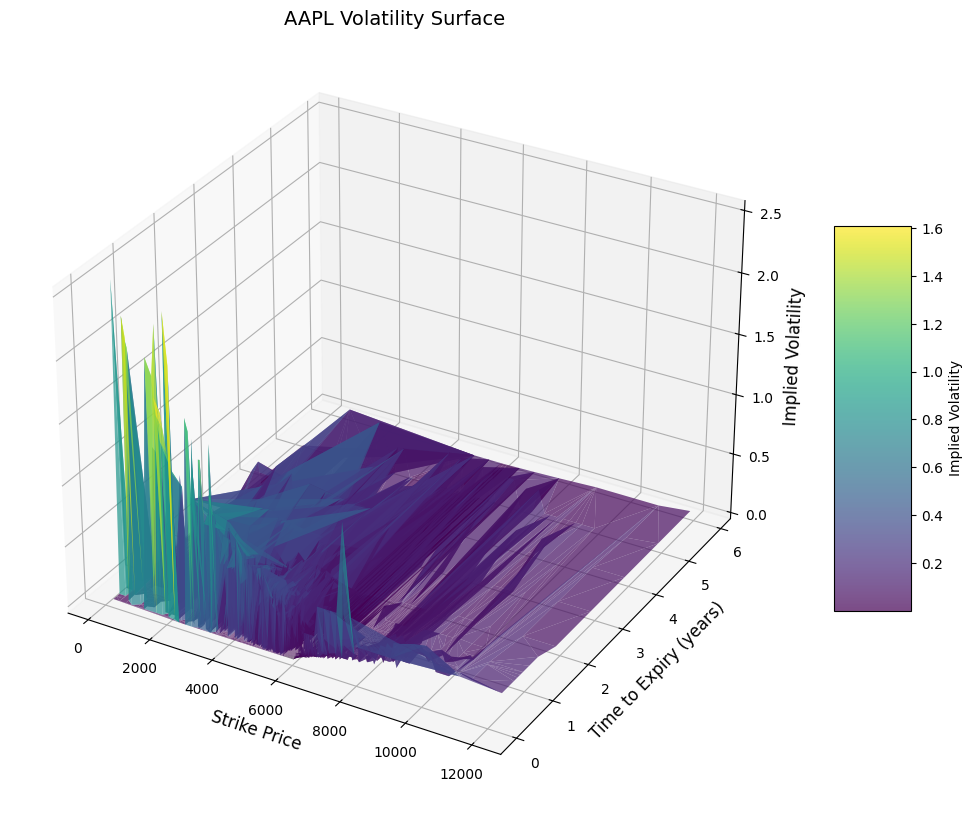

In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import datetime

# Fetch AAPL options data
aapl = yf.Ticker("^SPX")
exp_dates = aapl.options  # Get available expiration dates

strikes = []
ttes = []  # Time to expiration (years)
ivs = []   # Implied volatilities

today = datetime.date.today()

for exp_date_str in exp_dates:
    try:
        # Get options chain for the current expiration date
        opt_chain = aapl.option_chain(exp_date_str)
        calls = opt_chain.calls  # Use call options
        
        # Calculate time to expiration
        exp_date = datetime.datetime.strptime(exp_date_str, "%Y-%m-%d").date()
        tte = (exp_date - today).days / 365.0  # Convert to years
        
        # Collect strike, IV, and TTE
        strikes.extend(calls['strike'].tolist())
        ivs.extend(calls['impliedVolatility'].tolist())
        ttes.extend([tte] * len(calls))
        
    except Exception as e:
        print(f"Skipping {exp_date_str}: {e}")

# Convert to numpy arrays for plotting
strikes = np.array(strikes)
ttes = np.array(ttes)
ivs = np.array(ivs)

# Create 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot triangulated surface
surf = ax.plot_trisurf(strikes, ttes, ivs, cmap='viridis', edgecolor='none', alpha=0.7)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Implied Volatility')

ax.set_xlabel('Strike Price', fontsize=12)
ax.set_ylabel('Time to Expiry (years)', fontsize=12)
ax.set_zlabel('Implied Volatility', fontsize=12)
ax.set_title('AAPL Volatility Surface', fontsize=14)

plt.show()

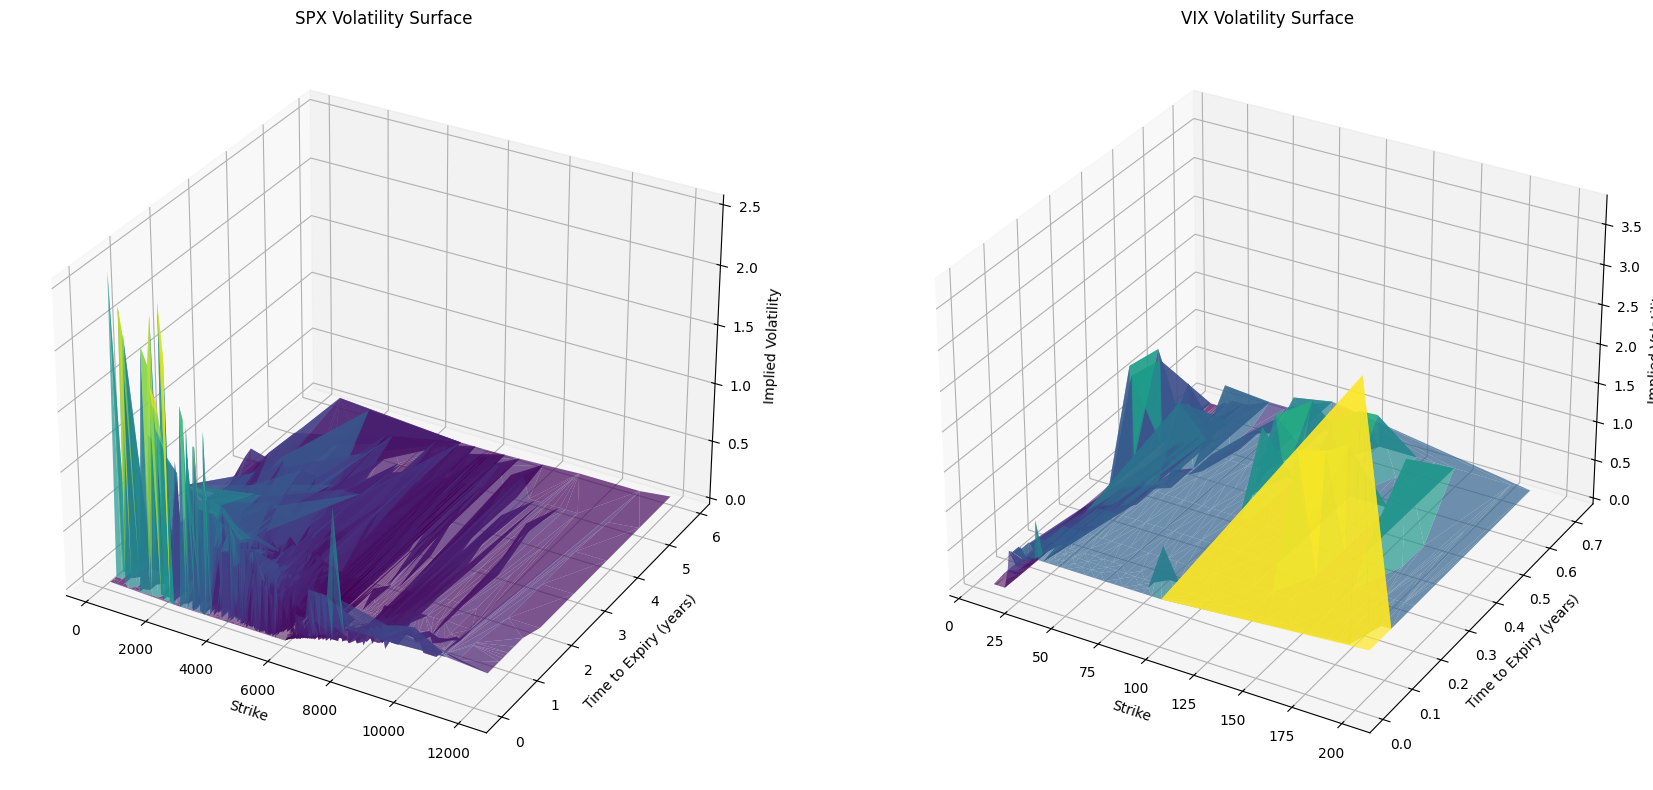

In [17]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime

def get_vol_surface(ticker):
    try:
        obj = yf.Ticker(ticker)
        exp_dates = obj.options  # Get expiration dates
        today = datetime.date.today()
        
        strikes, ttes, ivs = [], [], []
        
        for exp_date_str in exp_dates:
            try:
                # Get options chain
                chain = obj.option_chain(exp_date_str).calls
                exp_date = datetime.datetime.strptime(exp_date_str, "%Y-%m-%d").date()
                tte = (exp_date - today).days / 365.0  # Time to expiration in years
                
                # Append data
                strikes.extend(chain['strike'])
                ivs.extend(chain['impliedVolatility'])
                ttes.extend([tte] * len(chain))
            except Exception as e:
                print(f"Skipping {exp_date_str}: {e}")
                continue
        
        return np.array(strikes), np.array(ttes), np.array(ivs)
    
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return None, None, None

# Plotting function
def plot_vol_surface(ax, strikes, ttes, ivs, title):
    if strikes is None or len(strikes) == 0:
        print(f"No data to plot for {title}")
        return
    
    ax.plot_trisurf(strikes, ttes, ivs, cmap='viridis', edgecolor='none', alpha=0.7)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Time to Expiry (years)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)

# Fetch data for SPX and VIX
spx_strikes, spx_ttes, spx_ivs = get_vol_surface("^SPX")
vix_strikes, vix_ttes, vix_ivs = get_vol_surface("^VIX")

# Create 3D plots
fig = plt.figure(figsize=(18, 8))

# SPX Plot
ax1 = fig.add_subplot(121, projection='3d')
plot_vol_surface(ax1, spx_strikes, spx_ttes, spx_ivs, "SPX Volatility Surface")

# VIX Plot
ax2 = fig.add_subplot(122, projection='3d')
plot_vol_surface(ax2, vix_strikes, vix_ttes, vix_ivs, "VIX Volatility Surface")

plt.tight_layout()
plt.show()

In [2]:
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata
import datetime

def fetch_vol_surface(ticker):
    try:
        obj = yf.Ticker(ticker)
        exp_dates = obj.options
        today = datetime.date.today()
        
        strikes, ttes, ivs = [], [], []
        
        for exp_date_str in exp_dates:
            try:
                chain = obj.option_chain(exp_date_str).calls
                exp_date = datetime.datetime.strptime(exp_date_str, "%Y-%m-%d").date()
                tte = (exp_date - today).days / 365.0
                
                strikes.extend(chain['strike'])
                ivs.extend(chain['impliedVolatility'])
                ttes.extend([tte] * len(chain))
            except Exception as e:
                print(f"Skipping {exp_date_str}: {e}")
                continue
        
        return np.array(strikes), np.array(ttes), np.array(ivs)
    
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return None, None, None

def create_interactive_surface(strikes, ttes, ivs, title):
    if strikes is None or len(strikes) == 0:
        print(f"No data to plot for {title}")
        return None
    
    # Interpolate data onto a denser grid
    grid_strikes, grid_tes = np.meshgrid(
        np.linspace(strikes.min(), strikes.max(), 100),  # Increased grid resolution
        np.linspace(ttes.min(), ttes.max(), 100)
    )
    grid_ivs = griddata(
        (strikes, ttes), ivs,
        (grid_strikes, grid_tes),
        method='cubic'
    )
    
    # Create plot with larger dimensions
    fig = go.Figure(data=[go.Surface(
        x=grid_strikes,
        y=grid_tes,
        z=grid_ivs,
        colorscale='Viridis',
        hovertemplate="Strike: %{x}<br>TTE: %{y:.2f} yrs<br>IV: %{z:.2f}<extra></extra>"
    )])
    
    fig.update_layout(
        title=dict(text=title, font=dict(size=24)),  # Larger title
        scene=dict(
            xaxis_title='Strike Price',
            yaxis_title='Time to Expiry (years)',
            zaxis_title='Implied Volatility',
            camera=dict(eye=dict(x=1.8, y=1.8, z=0.7)),  # Wider viewing angle
            xaxis=dict(title_font=dict(size=18)),  # Larger axis labels
            yaxis=dict(title_font=dict(size=18)),
            zaxis=dict(title_font=dict(size=18))
        ),
        autosize=False,
        width=1200,  # Set explicit width/height
        height=800,
        margin=dict(l=20, r=20, b=20, t=50)  # Minimize margins
    )
    
    return fig

# Fetch data
spx_strikes, spx_ttes, spx_ivs = fetch_vol_surface("^SPX")  # Use "SPY" if SPX fails
vix_strikes, vix_ttes, vix_ivs = fetch_vol_surface("^VIX")

# Generate and display plots
spx_fig = create_interactive_surface(spx_strikes, spx_ttes, spx_ivs, "SPX Volatility Surface")
vix_fig = create_interactive_surface(vix_strikes, vix_ttes, vix_ivs, "VIX Volatility Surface")

if spx_fig:
    spx_fig.show(config={'scrollZoom': True})  # Enable scroll-to-zoom
if vix_fig:
    vix_fig.show(config={'scrollZoom': True})